##### Copyright 2020 Flávia Béo

# Q RNN para número Cromático de Grafos

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
from cirq.contrib.svg import SVGCircuit

from qiskit.aqua.operators import Z, Y, X
from qiskit.aqua.operators import StateFn

from qiskit.tools.visualization import circuit_drawer

from qiskit import Aer, ClassicalRegister, execute, QuantumCircuit, QuantumRegister, IBMQ

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

print(tf.__version__)

2.1.0


### Configurações 

Para configurar a rede base para uso no **IBM Quantum Experience**:

- Usar o API token como variável de ambiente;
- Salvar o token para não precisar reiniciar;
- De preferência usar uma virtualenv.

In [3]:
QUBITS = 4
operatorZ = Z ^ Z ^ Z ^ Z
operatorX = X ^ X ^ X ^ X
operatorY = Y ^ Y ^ Y ^ Y


def quantum_layer(initial_parameters):
    quantumRegister = QuantumRegister(QUBITS)
    quantumCircuit = QuantumCircuit(quantumRegister)
    
    quantumCircuit.h(range(4))

    for i in range(len(initial_parameters)):
        quantumCircuit.ry(initial_parameters[i] * np.pi, i)
   
    psi = StateFn(quantumCircuit)
    
    expectationX = (~psi @ operatorX @ psi).eval()
    expectationZ = psi.adjoint().compose(operatorZ).compose(psi).eval().real
    expectationY = (~psi @ operatorY @ psi).eval()
    
    expectationZ = np.abs(np.real(expectationZ))
    expectations = [expectationX, expectationY, expectationZ, 
                    expectationX + expectationY + expectationZ] 

    return np.array(expectations)

### Camadas da rede 

Criar uma classe para **Quantum Layer**:

In [4]:
class Linear(keras.layers.Layer):
    def __init__(self, batch_size=64, units=4,**kwargs):
        super(Linear, self).__init__(**kwargs)

    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def call(self, inputs):
        
        if(tf.executing_eagerly()):
            final_output = []
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs[i].numpy())
                final_output.append(list(pred))
            return tf.convert_to_tensor(final_output)
        return inputs

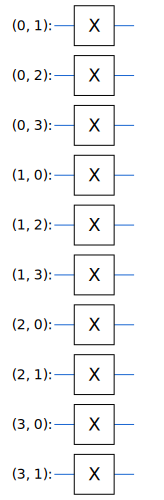

In [11]:
def convert_to_circuit(node):
    values = np.ndarray.flatten(node)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

x_train_circ = [convert_to_circuit(x) for x in train_set]

SVGCircuit(x_train_circ[0])

O circuito acima representa a disposição dos **qbits** que farão parte da camada interna **Linear**

### Ler o dataset 

O dataset gerado tem grafos de 50 vértices, e configurações de arestas aleatórias. O **label** nesse caso será o número cromático.

In [5]:
def read_graph(filepath):
    with open(filepath,"r") as f:

        line = ''

        # Parse number of vertices
        while 'DIMENSION' not in line: line = f.readline();
        n = int(line.split()[1])
        Ma = np.zeros((n,n),dtype=int)
        
        # Parse edges
        while 'EDGE_DATA_SECTION' not in line: line = f.readline();
        line = f.readline()
        while '-1' not in line:
            i,j = [ int(x) for x in line.split() ]
            Ma[i,j] = 1
            line = f.readline()
        #end while

        # Parse diff edge
        while 'DIFF_EDGE' not in line: line = f.readline();
        diff_edge = [ int(x) for x in f.readline().split() ]

        # Parse target cost
        while 'CHROM_NUMBER' not in line: line = f.readline();
        chrom_number = int(f.readline().strip())

    #end
    return Ma,chrom_number,diff_edge

In [6]:
Ma,chrom_number,diff_edge = read_graph('qrnn-training-5/m0.graph')

In [7]:
pd.DataFrame(Ma)

,0,1,2,3
0,0,1,1,1
1,1,0,1,1
2,1,1,0,0
3,1,1,0,0


### Fazer o dataset de treino

In [8]:
train_graphs = []
train_c_nums = []

for filename in os.listdir('qrnn-training-5'):
    Ma,chrom_number,diff_edge = read_graph("{}{}".format('qrnn-training-5/',filename))
    train_graphs.append(Ma)
    train_c_nums.append(chrom_number)

In [9]:
train_set = np.array(train_graphs)
train_set.shape

(582, 4, 4)

O dataset de treino gerado tem 582 grafos com 4 vértices, esse número de vértices foi o número possível de implementar com a camada quântica incluída na rede. Para números maiores que esse, são necessários mais recursos e um outro tipo de circuito no qual eu não consegui chegar.

In [10]:
train_labels = np.array(train_c_nums)
train_labels.shape

(582,)

### Montar as Camadas

In [12]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(4, 4)))
model.add(keras.layers.Dense(4, activation='relu'))
model.add(Linear(name="layer_3"))
model.add(keras.layers.Dense(582, activation='softmax'))

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
            run_eagerly=True)

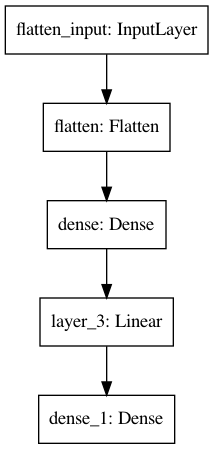

In [14]:
!pip install pydot
!pip install graphviz
!pip install pydotplus

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

A imagem acima é a rede implementada com a camada quântica **layer_3** entre as camadas **dense**, que segundo a referência que comentamos, tem uma cada interna, portanto pode ser classificada como deep também.

## Treino 💪

In [14]:
model.fit(train_set, train_labels, epochs=50)

Train on 582 samples
Epoch 1/50
582/582 [==============================] - 24s 41ms/sample - loss: 6.3441 - accuracy: 0.2440
Epoch 2/50
582/582 [==============================] - 30s 52ms/sample - loss: 6.2813 - accuracy: 0.7543
Epoch 3/50
 64/582 [==>...........................] - ETA: 26s - loss: 6.2460 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 34s 59ms/sample - loss: 6.2183 - accuracy: 1.0000
Epoch 4/50
582/582 [==============================] - 39s 67ms/sample - loss: 6.1550 - accuracy: 1.0000
Epoch 5/50
128/582 [=====>........................] - ETA: 29s - loss: 6.1115 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 49s 83ms/sample - loss: 6.0917 - accuracy: 1.0000
Epoch 6/50
582/582 [==============================] - 80s 137ms/sample - loss: 6.0283 - accuracy: 1.0000
Epoch 7/50
192/582 [========>.....................] - ETA: 23s - loss: 5.9738 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 31s 54ms/sample - loss: 5.9653 - accuracy: 1.0000
Epoch 8/50
582/582 [==============================] - 72s 125ms/sample - loss: 5.9022 - accuracy: 1.0000
Epoch 9/50
256/582 [============>.................] - ETA: 1:16 - loss: 5.8681 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 91s 156ms/sample - loss: 5.8388 - accuracy: 1.0000
Epoch 10/50
582/582 [==============================] - 40s 69ms/sample - loss: 5.7758 - accuracy: 1.0000
Epoch 11/50
320/582 [===============>..............] - ETA: 15s - loss: 5.7344 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 35s 60ms/sample - loss: 5.7128 - accuracy: 1.0000
Epoch 12/50
582/582 [==============================] - 33s 57ms/sample - loss: 5.6499 - accuracy: 1.0000
Epoch 13/50
384/582 [==================>...........] - ETA: 13s - loss: 5.5973 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 52s 90ms/sample - loss: 5.5862 - accuracy: 1.0000
Epoch 14/50
582/582 [==============================] - 48s 83ms/sample - loss: 5.5231 - accuracy: 1.0000
Epoch 15/50
448/582 [======================>.......] - ETA: 5s - loss: 5.4726 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 22s 38ms/sample - loss: 5.4600 - accuracy: 1.0000
Epoch 16/50
582/582 [==============================] - 20s 34ms/sample - loss: 5.3976 - accuracy: 1.0000
Epoch 17/50
544/582 [===========================>..] - ETA: 1s - loss: 5.3389 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 26s 45ms/sample - loss: 5.3347 - accuracy: 1.0000
Epoch 18/50
582/582 [==============================] - 33s 56ms/sample - loss: 5.2718 - accuracy: 1.0000
Epoch 19/50
582/582 [==============================] - 36s 61ms/sample - loss: 5.2091 - accuracy: 1.0000
Epoch 20/50


582/582 [==============================] - 31s 53ms/sample - loss: 5.1464 - accuracy: 1.0000
Epoch 21/50
582/582 [==============================] - 35s 59ms/sample - loss: 5.0840 - accuracy: 1.0000
Epoch 22/50
 64/582 [==>...........................] - ETA: 37s - loss: 5.1080 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 44s 76ms/sample - loss: 5.0210 - accuracy: 1.0000
Epoch 23/50
582/582 [==============================] - 103s 177ms/sample - loss: 4.9584 - accuracy: 1.0000
Epoch 24/50
128/582 [=====>........................] - ETA: 30s - loss: 4.9053 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 39s 67ms/sample - loss: 4.8958 - accuracy: 1.0000
Epoch 25/50
582/582 [==============================] - 35s 61ms/sample - loss: 4.8330 - accuracy: 1.0000
Epoch 26/50
192/582 [========>.....................] - ETA: 26s - loss: 4.7616 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 40s 70ms/sample - loss: 4.7708 - accuracy: 1.0000
Epoch 27/50
582/582 [==============================] - 41s 70ms/sample - loss: 4.7086 - accuracy: 1.0000
Epoch 28/50
256/582 [============>.................] - ETA: 23s - loss: 4.6883 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 37s 63ms/sample - loss: 4.6466 - accuracy: 1.0000
Epoch 29/50
582/582 [==============================] - 28s 48ms/sample - loss: 4.5848 - accuracy: 1.0000
Epoch 30/50
320/582 [===============>..............] - ETA: 20s - loss: 4.5153 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 71s 122ms/sample - loss: 4.5225 - accuracy: 1.0000
Epoch 31/50
582/582 [==============================] - 57s 98ms/sample - loss: 4.4602 - accuracy: 1.0000
Epoch 32/50
384/582 [==================>...........] - ETA: 12s - loss: 4.4205 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 36s 62ms/sample - loss: 4.3984 - accuracy: 1.0000
Epoch 33/50
582/582 [==============================] - 46s 78ms/sample - loss: 4.3366 - accuracy: 1.0000
Epoch 34/50
448/582 [======================>.......] - ETA: 10s - loss: 4.2904 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 43s 74ms/sample - loss: 4.2748 - accuracy: 1.0000
Epoch 35/50
582/582 [==============================] - 42s 72ms/sample - loss: 4.2137 - accuracy: 1.0000
Epoch 36/50
512/582 [=========================>....] - ETA: 3s - loss: 4.1614 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 33s 56ms/sample - loss: 4.1524 - accuracy: 1.0000
Epoch 37/50
582/582 [==============================] - 25s 44ms/sample - loss: 4.0913 - accuracy: 1.0000
Epoch 38/50
582/582 [==============================] - 22s 38ms/sample - loss: 4.0303 - accuracy: 1.0000


Epoch 39/50
582/582 [==============================] - 23s 40ms/sample - loss: 3.9695 - accuracy: 1.0000
Epoch 40/50
582/582 [==============================] - 24s 42ms/sample - loss: 3.9092 - accuracy: 1.0000
Epoch 41/50
 64/582 [==>...........................] - ETA: 24s - loss: 3.8808 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 27s 46ms/sample - loss: 3.8487 - accuracy: 1.0000
Epoch 42/50
582/582 [==============================] - 23s 40ms/sample - loss: 3.7889 - accuracy: 1.0000
Epoch 43/50
160/582 [=======>......................] - ETA: 18s - loss: 3.7796 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 28s 47ms/sample - loss: 3.7290 - accuracy: 1.0000
Epoch 44/50
582/582 [==============================] - 33s 57ms/sample - loss: 3.6697 - accuracy: 1.0000
Epoch 45/50
224/582 [==========>...................] - ETA: 18s - loss: 3.5843 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 29s 49ms/sample - loss: 3.6106 - accuracy: 1.0000
Epoch 46/50
582/582 [==============================] - 28s 48ms/sample - loss: 3.5510 - accuracy: 1.0000
Epoch 47/50
288/582 [=============>................] - ETA: 13s - loss: 3.4879 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 26s 45ms/sample - loss: 3.4919 - accuracy: 1.0000
Epoch 48/50
582/582 [==============================] - 27s 46ms/sample - loss: 3.4337 - accuracy: 1.0000
Epoch 49/50
352/582 [=================>............] - ETA: 10s - loss: 3.3840 - accuracy: 1.0000WARNING:tensorflow:Gradients do not exist for variables ['dense/kernel:0', 'dense/bias:0'] when minimizing the loss.


582/582 [==============================] - 27s 46ms/sample - loss: 3.3758 - accuracy: 1.0000
Epoch 50/50
582/582 [==============================] - 25s 44ms/sample - loss: 3.3183 - accuracy: 1.0000


### Fazer dataset de Teste

In [173]:
test_graphs = []
test_c_nums = []

for filename in os.listdir('qrnn-testing-5'):
    Ma,chrom_number,diff_edge = read_graph("{}{}".format('qrnn-testing-5/',filename))
    test_graphs.append(Ma)
    test_c_nums.append(chrom_number)

In [174]:
test_set = np.array(test_graphs)
test_set.shape

(180, 4, 4)

In [175]:
test_labels = np.array(test_c_nums)
test_labels.shape

(180,)

## Acurácia

In [176]:
test_loss, test_acc = model.evaluate(test_set,  test_labels, verbose=2)

180/180 - 8s - loss: 1.6918 - accuracy: 0.9667


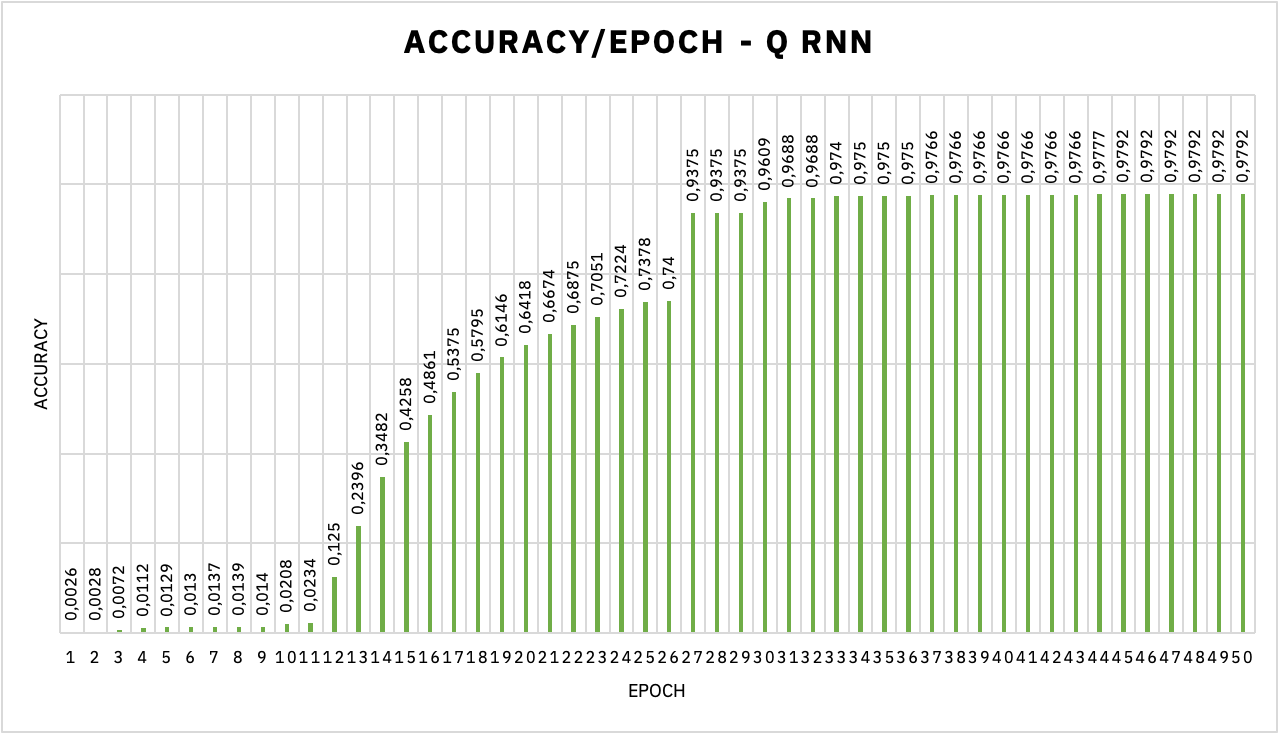

In [15]:
from IPython.display import display, Image
display(Image(filename='accuracy_.png'))

(imagem produzida com os valores do teste feito com essa implementação)

O modelo com a camada quântica obteve resultados de **96,67%** no dataset de testes de **180** grafos para encontrar o número cromático.
Foi possível reproduzir o exato dataset para execução do código dos autores do artigo sobre a rede neural deep para o mesmo propósito de encontrar o número mínimo cromático para os grafos.

O modelo clássico obteve resultados de **82%** no dataset de testes com grafos para encontrar o número cromático.
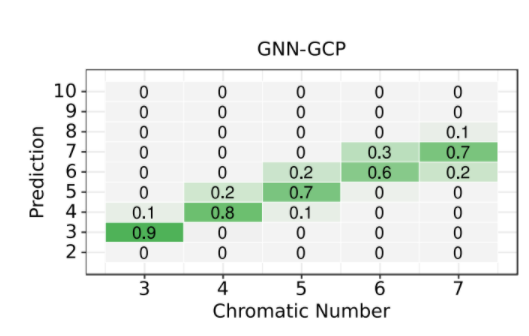
(imagem dos autores do artigo)

- O tempo total de treino para o ambos foi de em torno de 25 minutos, com diferença mínima de segundos um para outro.
- A diferença notada, foi que a rede quântica apresentada aqui, atingiu essa acurácia em 50 epochs, enquanto a rede clássica atingiu a acurácia de 82% em 98 epochs.
- A convergência da rede quântica foi mais rápida.
- O código dos autores estava bem desatualizado, versões antigas das bibliotecas etc, talves seja algo a ser considerado.